# Measuring dependency relations' degree of functionality

It would be cool if we had a measurment for a relation's degree of functionality, that is, whether it mainly takes functional dependents or content dependents. Here's my suggestion.

My suggestion relies on three assumptions:

- A functional deprel is present in as many languages as possible. This can be measured with the mean probability of a deprel over all languages.
- A functional deprel is also a closed class, meaning the amount of word dependents should be relatively small. This can be measured by the conditional entropy of the probability distribution of all word dependents given the deprel. This is then averaged across all languages.
- A functional deprel has an equal distribution in all languages. This can be measured by the conditional entropy of a deprel given its cross-lingual probability distribution. I'm not sure about this one.

More concisely, this tells us:

### Crosslingual deprel entropy

"It should be equally common in all languages"

### Crosslingual deprel probability

"It should be a common relation in all languages"

### Inverse word entropy

"It should have a small number of word dependents"


## Summary

Inverse word entropy works best alone, while crosslingual deprel entropy and crosslingual deprel probability both have their weaknesses.

In [1]:
# Matplotlib
%matplotlib inline
import matplotlib
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 7.0)
matplotlib.style.use('ggplot')

# Remove warnings
import warnings
#warnings.filterwarnings('ignore')

import sys, os
from os.path import join
sys.path.append("../tools/")
from collections import defaultdict

# Data management libraries
import pandas as pd
import seaborn as sns
import scipy as sp

# Treebank utils, found in "../tools"
import udeval, udtree, lang_utils, dependency_classes

file_format = "conllx"
train_type = "train"
gold_output_base = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/universaldependencies1-1/ud-treebanks-v1.1/"
file_prefix = "degree_of_functionality"

gold_files = lang_utils.get_ud_paths(gold_output_base, type_=train_type, format_=file_format)

def word_dependent_entropy(trees):
    # dep_word_freqs[deprel][word] = freq
    dep_word_freqs = defaultdict(lambda : defaultdict(int))
    total = 0
    for tree in trees:
        for word, deprel in zip(tree.words, tree.deprels):
            deprel = deprel.split(":")[0]
            dep_word_freqs[deprel][word] += 1
    df = pd.DataFrame(dep_word_freqs).fillna(0)  # frequencies
    df = df.divide(df.sum(axis=0), axis=1)       # word probability conditioned on deprel
    entropy_upper_bound = np.log(len(df.index))
    df = pd.Series(sp.stats.entropy(df), index=df.columns).sort_values()
    return df / entropy_upper_bound  # normalize

def inverse_word_entropy(treebanks):
    lang_entropies = {}
    for lang, treebank in treebanks.items():
        lang_entropies[lang] = word_dependent_entropy(udtree.from_files(treebank))
    return 1 - (pd.DataFrame(lang_entropies).fillna(1)).mean(axis=1).sort_values()

def crosslingual_deprel_entropy(treebanks):
    # dep_word_freqs[lang][deprel] = freq
    dep_freqs = defaultdict(lambda : defaultdict(int))
    total = 0
    for lang, treebank in treebanks.items():
        for tree in udtree.from_files(treebank):
            for deprel in tree.deprels:
                deprel = deprel.split(":")[0]
                dep_freqs[lang][deprel] += 1
    df = pd.DataFrame(dep_freqs).fillna(0)  # frequencies
    df = df.divide(df.sum(axis=1), axis=0).transpose()
    entropy_upper_bound = np.log(len(df.index))  # ln num_deprels
    df = pd.Series(sp.stats.entropy(df), index=df.columns) / entropy_upper_bound
    return df.sort_values()

def crosslingual_deprel_probability(treebanks):
    # dep_word_freqs[lang][deprel] = freq
    dep_freqs = defaultdict(lambda : defaultdict(int))
    total = 0
    for lang, treebank in treebanks.items():
        for tree in udtree.from_files(treebank):
            for deprel in tree.deprels:
                deprel = deprel.split(":")[0]
                dep_freqs[lang][deprel] += 1
    df = pd.DataFrame(dep_freqs).fillna(0)  # frequencies
    df = df.divide(df.sum(axis=0), axis=1).mean(axis=1).sort_values()
    return df

/Users/jimmy/dev/miniconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
crosslingual_probabilities = crosslingual_deprel_probability(gold_files)
crosslingual_entropies = crosslingual_deprel_entropy(gold_files)
inverse_word_entropies = inverse_word_entropy(gold_files)

## Inverse word entropy

In [6]:
inverse_word_entropies.sort_values(ascending=False).to_csv('../data/' + file_prefix + '.inverse_word_entropy.csv')
inverse_word_entropies.sort_values(ascending=False)

neg           0.906746
cc            0.876866
punct         0.843860
mark          0.767365
cop           0.755900
aux           0.694529
det           0.677719
case          0.660734
auxpass       0.522825
nummod        0.504892
mwe           0.500754
compound      0.475974
csubj         0.470102
advmod        0.467589
vocative      0.467119
discourse     0.443501
dep           0.441285
iobj          0.435675
parataxis     0.389564
expl          0.378647
appos         0.368528
ccomp         0.361064
csubjpass     0.354143
acl           0.345282
xcomp         0.340404
advcl         0.333394
nsubj         0.325456
name          0.299364
dobj          0.294814
amod          0.283292
root          0.274170
nsubjpass     0.266686
foreign       0.262379
dislocated    0.244197
conj          0.216640
goeswith      0.211904
nmod          0.205289
list          0.188206
remnant       0.139189
reparandum    0.083758
subj          0.022989
dtype: float64

__We don't like that expl is so far down__

This is due to expl not being used in all languages (see appendix at bottom). The other parts are quite good, though.

## Inverse word entropy * crosslingual entropy

neg           0.809632
cc            0.698825
punct         0.672415
mark          0.640270
cop           0.624611
aux           0.611682
det           0.529783
case          0.513979
nummod        0.391762
mwe           0.385281
advmod        0.359418
compound      0.331069
vocative      0.330740
auxpass       0.329437
parataxis     0.308975
ccomp         0.297341
advcl         0.286604
acl           0.278231
appos         0.274325
nsubj         0.272079
csubj         0.267724
iobj          0.265323
discourse     0.263708
dep           0.248035
csubjpass     0.237907
name          0.235632
xcomp         0.232271
dobj          0.225696
root          0.220622
expl          0.216917
nsubjpass     0.203703
amod          0.198608
conj          0.172268
nmod          0.165530
dislocated    0.076015
remnant       0.067931
goeswith      0.051361
list          0.044773
foreign       0.032267
reparandum    0.008850
subj          0.000000
dtype: float64

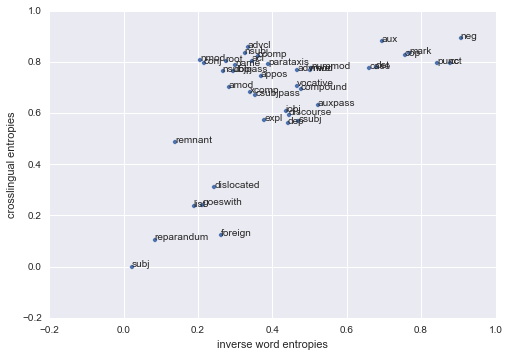

In [4]:
entropies = pd.concat([inverse_word_entropies, crosslingual_entropies], axis=1).rename(columns={0: "inverse word entropies", 1: "crosslingual entropies"})
ax = entropies.plot(kind='scatter', x="inverse word entropies", y="crosslingual entropies")
for label, x, y in entropies.itertuples():
    ax.annotate(label, (x, y))
    
(entropies["inverse word entropies"] * entropies["crosslingual entropies"]).sort_values(ascending=False)

__We don't like that advmod, vocative, and compound are so far up__

This is due to classes being _equally unprobable_ in all languages.

## Inverse word entropy * crosslingual probability

punct         1.028645e-01
case          5.883863e-02
det           4.871309e-02
nmod          2.870280e-02
cc            2.839094e-02
nsubj         2.276820e-02
advmod        1.997074e-02
amod          1.741265e-02
mark          1.724125e-02
root          1.701138e-02
aux           1.488078e-02
dobj          1.428176e-02
cop           1.135727e-02
conj          1.112050e-02
compound      9.001420e-03
nummod        7.444041e-03
acl           7.127510e-03
neg           6.784747e-03
name          6.012726e-03
advcl         5.062132e-03
ccomp         4.513287e-03
xcomp         3.994402e-03
appos         3.950078e-03
iobj          2.777516e-03
dep           2.656758e-03
mwe           2.256752e-03
auxpass       1.557776e-03
nsubjpass     1.405420e-03
parataxis     1.379987e-03
csubj         1.316302e-03
expl          7.671693e-04
discourse     4.045935e-04
vocative      1.243659e-04
remnant       9.446918e-05
foreign       4.498107e-05
list          3.374478e-05
csubjpass     1.708485e-05
g

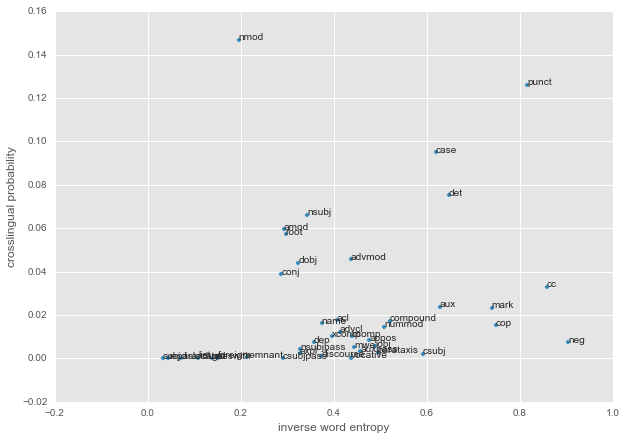

In [46]:
entropies = pd.concat([inverse_word_entropies, crosslingual_probabilities], axis=1).rename(columns={0: "inverse word entropy", 1: "crosslingual probability"})
ax = entropies.plot(kind='scatter', x="inverse word entropy", y="crosslingual probability")
for label, x, y in entropies.itertuples():
    ax.annotate(label, (x, y))
    
(entropies["inverse word entropy"] * entropies["crosslingual probability"]).sort_values(ascending=False)

### We don't like that nmod is so far up

This is due to it being a quite common content class.

# Conclusion

Using inverse word entropy seems to be the best measurment so far.


## Appendix: Heatmap of inverse word entropy

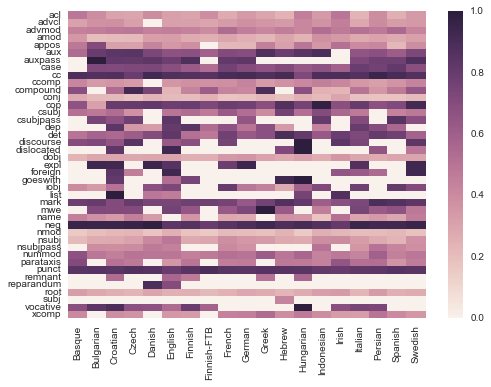

In [9]:
def lang_iwe(treebanks):
    lang_entropies = {}
    for lang, treebank in treebanks.items():
        lang_entropies[lang] = word_dependent_entropy(udtree.from_files(treebank))
    return 1 - (pd.DataFrame(lang_entropies).fillna(1))

sns.heatmap(lang_iwe(gold_files))